https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation

from utils import ls, cat


In [2]:
DATA_DIR = '../../data'

ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
 13.9 MB ../../data/train_lemmas.csv
 22.7 MB ../../data/train_tokens.csv


In [9]:
df = pd.read_csv(f'{DATA_DIR}/train_lemmas.csv', index_col=0)
df

,title,text
0,войско вступить предел,закончиться отступление германец приблизиться ...
1,столетие отложить,народный просвещение вид происходить чрезвычай...
2,ist,капитан день увидеть район лететь расположение...
3,гонец,корреспондент рассказывать случай порадует дру...
4,поймать швабский зверь,приехать передавать доставить швабский зверь в...
...,...,...
9995,граница стрелять водитель нарушитель,приказать наряд милиция приграничный блокпост ...
9996,губернатор,вести активный диалог губернатор лидер думский...
9997,съедутся клоун мир,июль открываться фестиваль клоунада смотр колл...
9998,выигрывать чемпионский титул,американский получиться финал теннисный турнир...


In [10]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [14]:
data_samples = df.head(n_samples)['title'].fillna('')
data_samples

0                      войско вступить предел
1                           столетие отложить
2                                         ist
3                                       гонец
4                      поймать швабский зверь
                        ...                  
1995     взяться свободный экономический зона
1996            шагать планета инфицированных
1997                 подрывник закурить забой
1998                 приговор убийца отложить
1999    решить ограничивать возраст президент
Name: title, Length: 2000, dtype: object

In [15]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()


Extracting tf-idf features for NMF...
done in 0.035s.
Extracting tf features for LDA...
done in 0.030s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.118s.


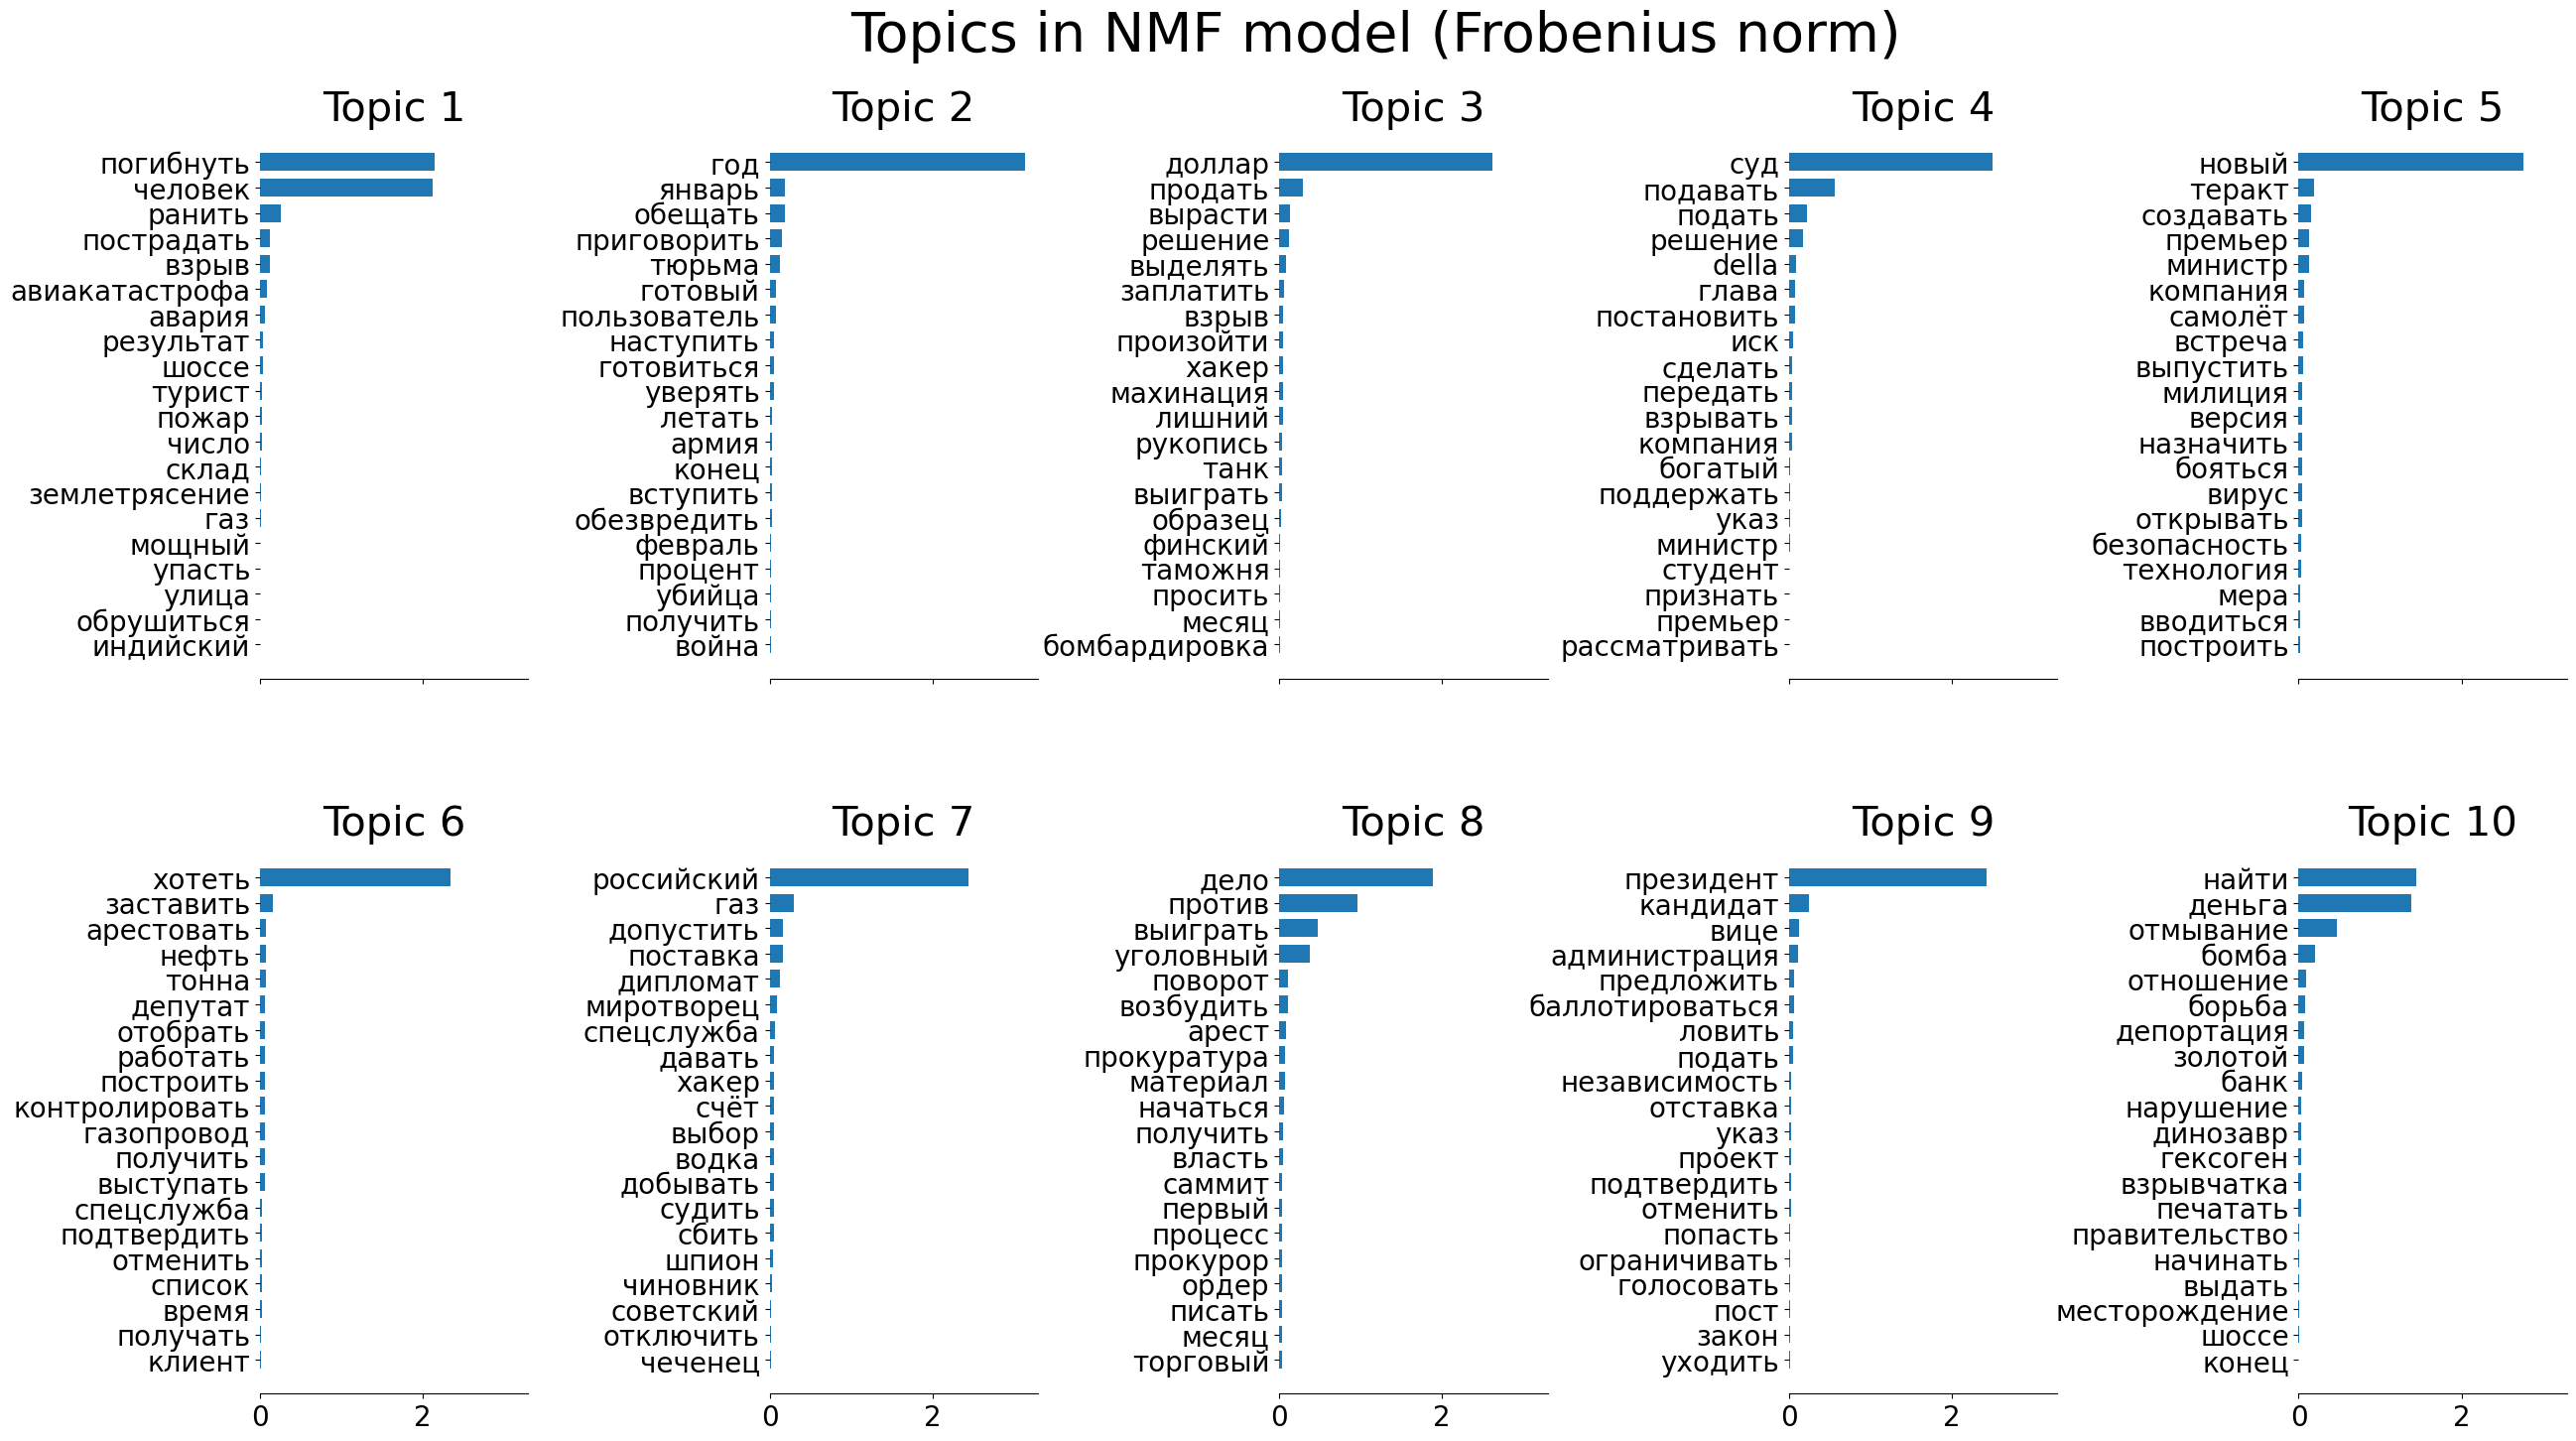

In [16]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)





 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.088s.


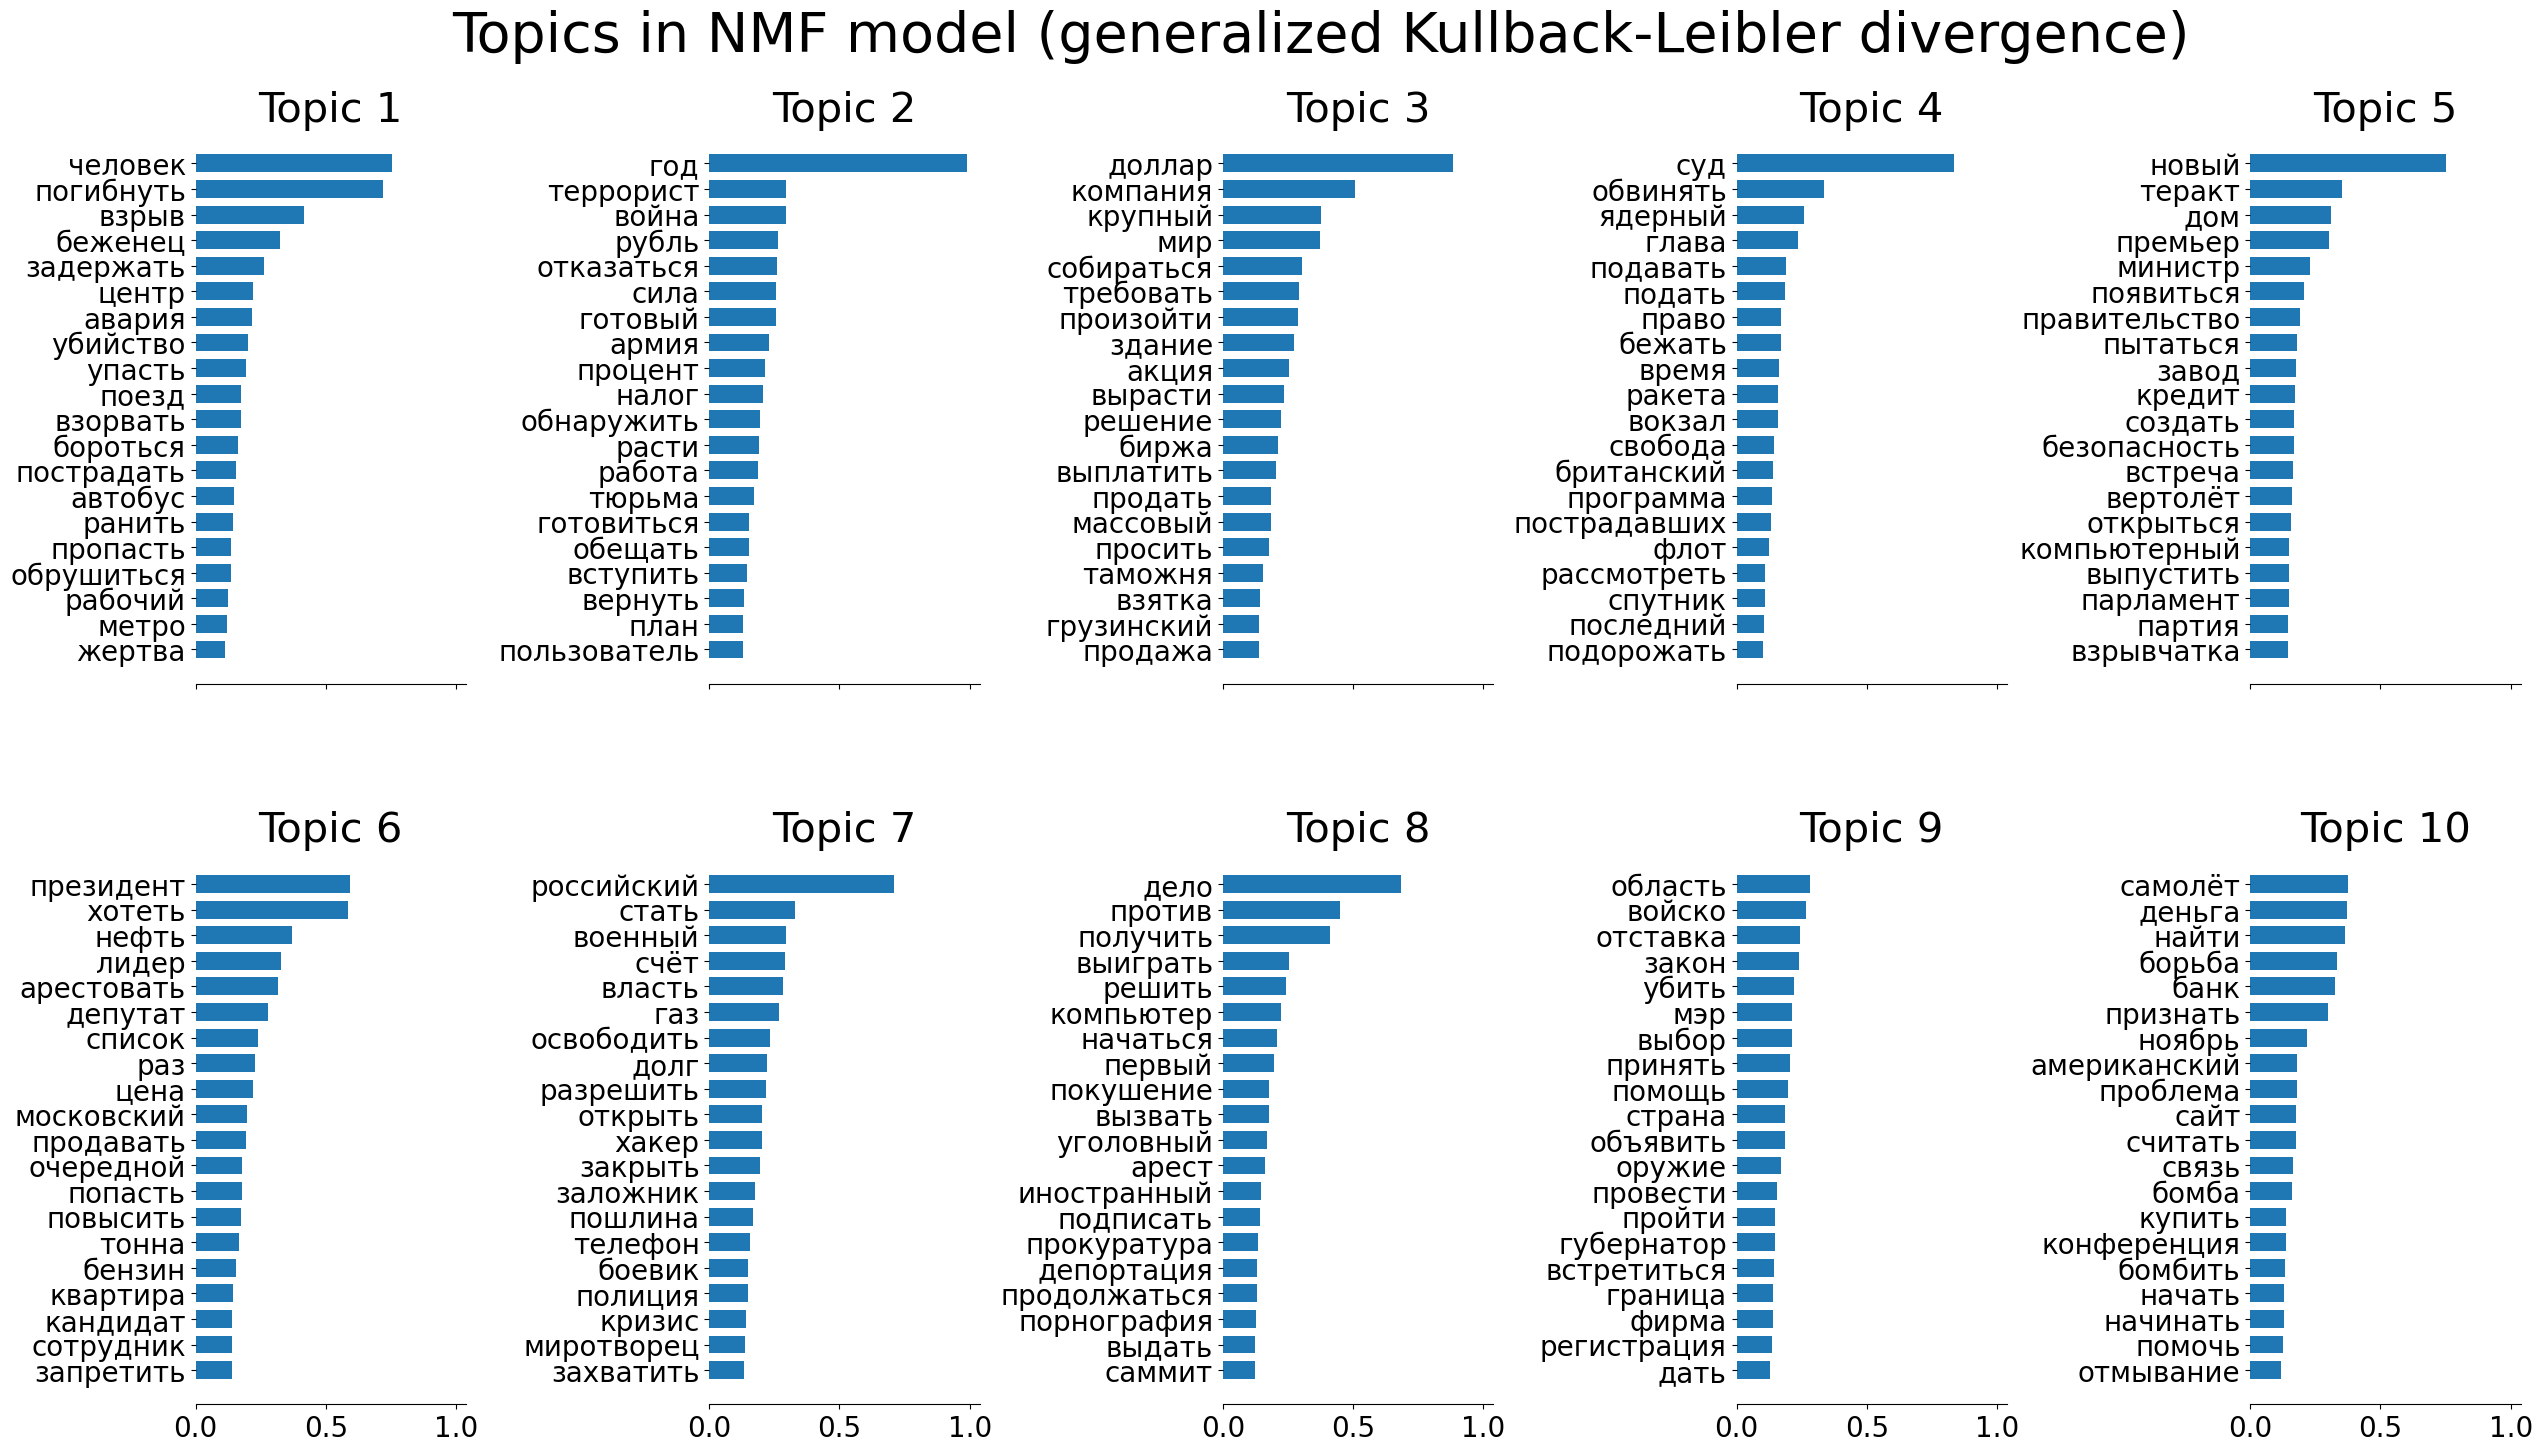

In [17]:
# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)




 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.014s.


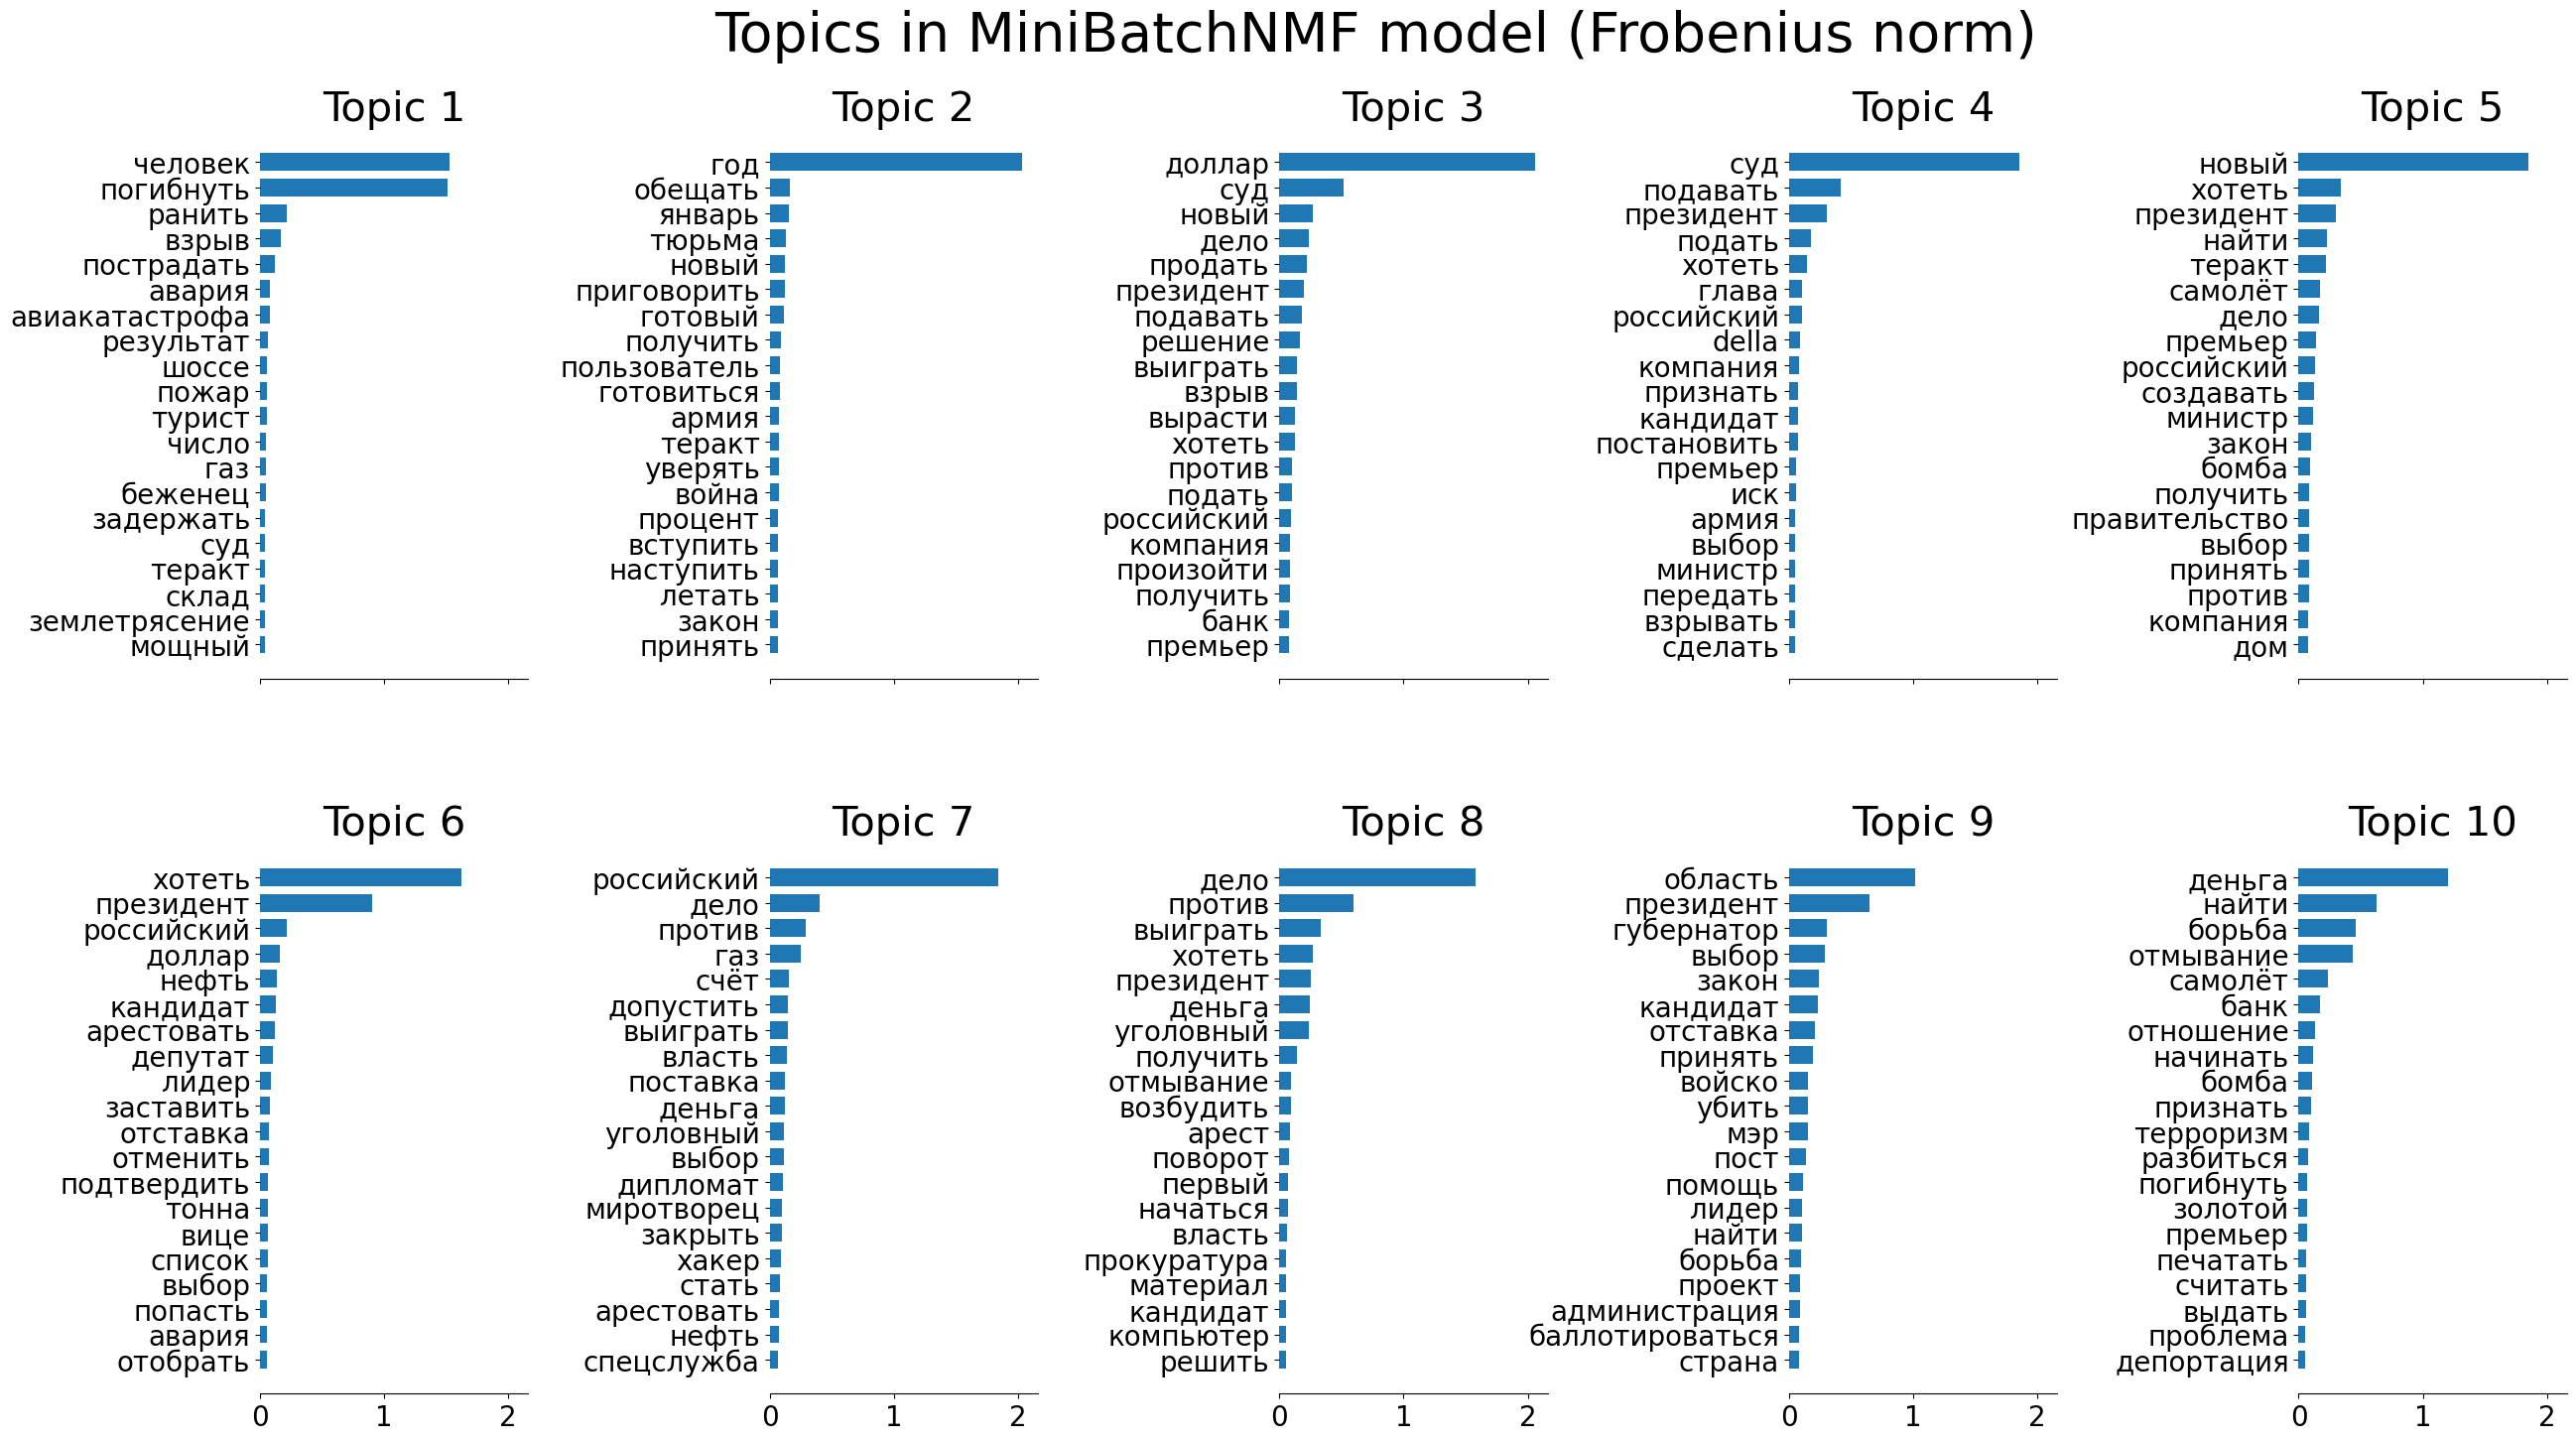

In [18]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)





 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.122s.


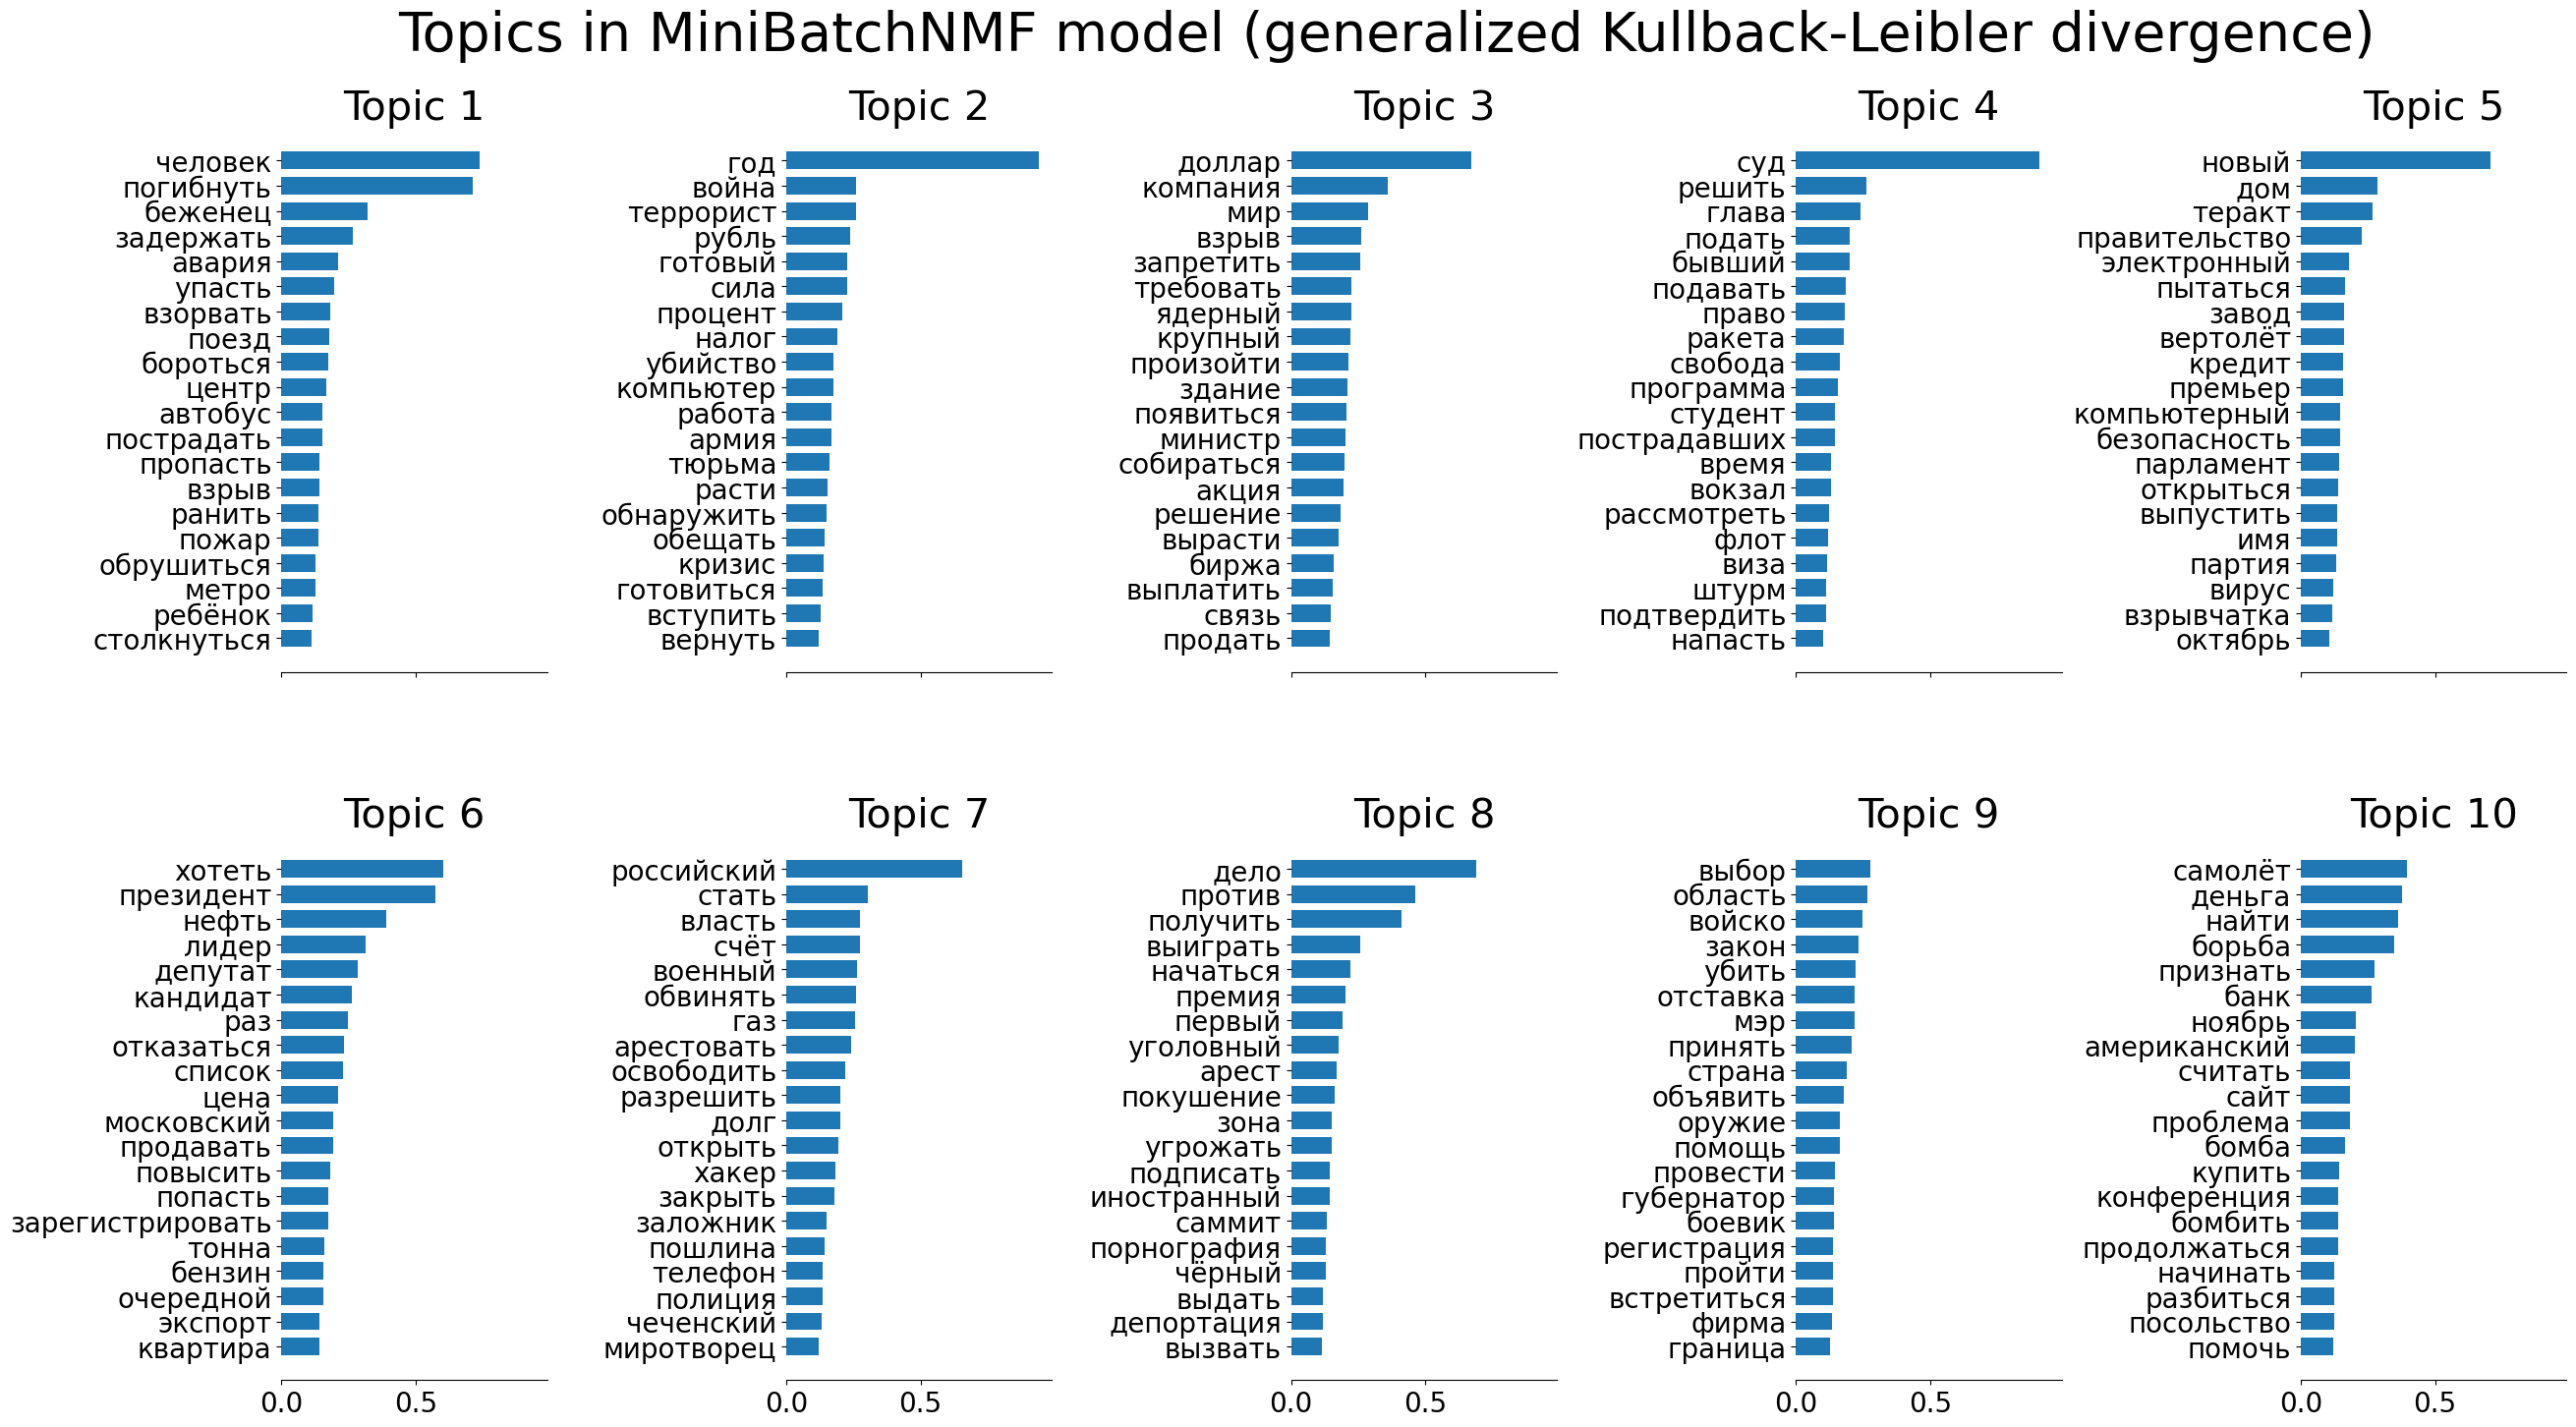

In [19]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)




 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 0.702s.


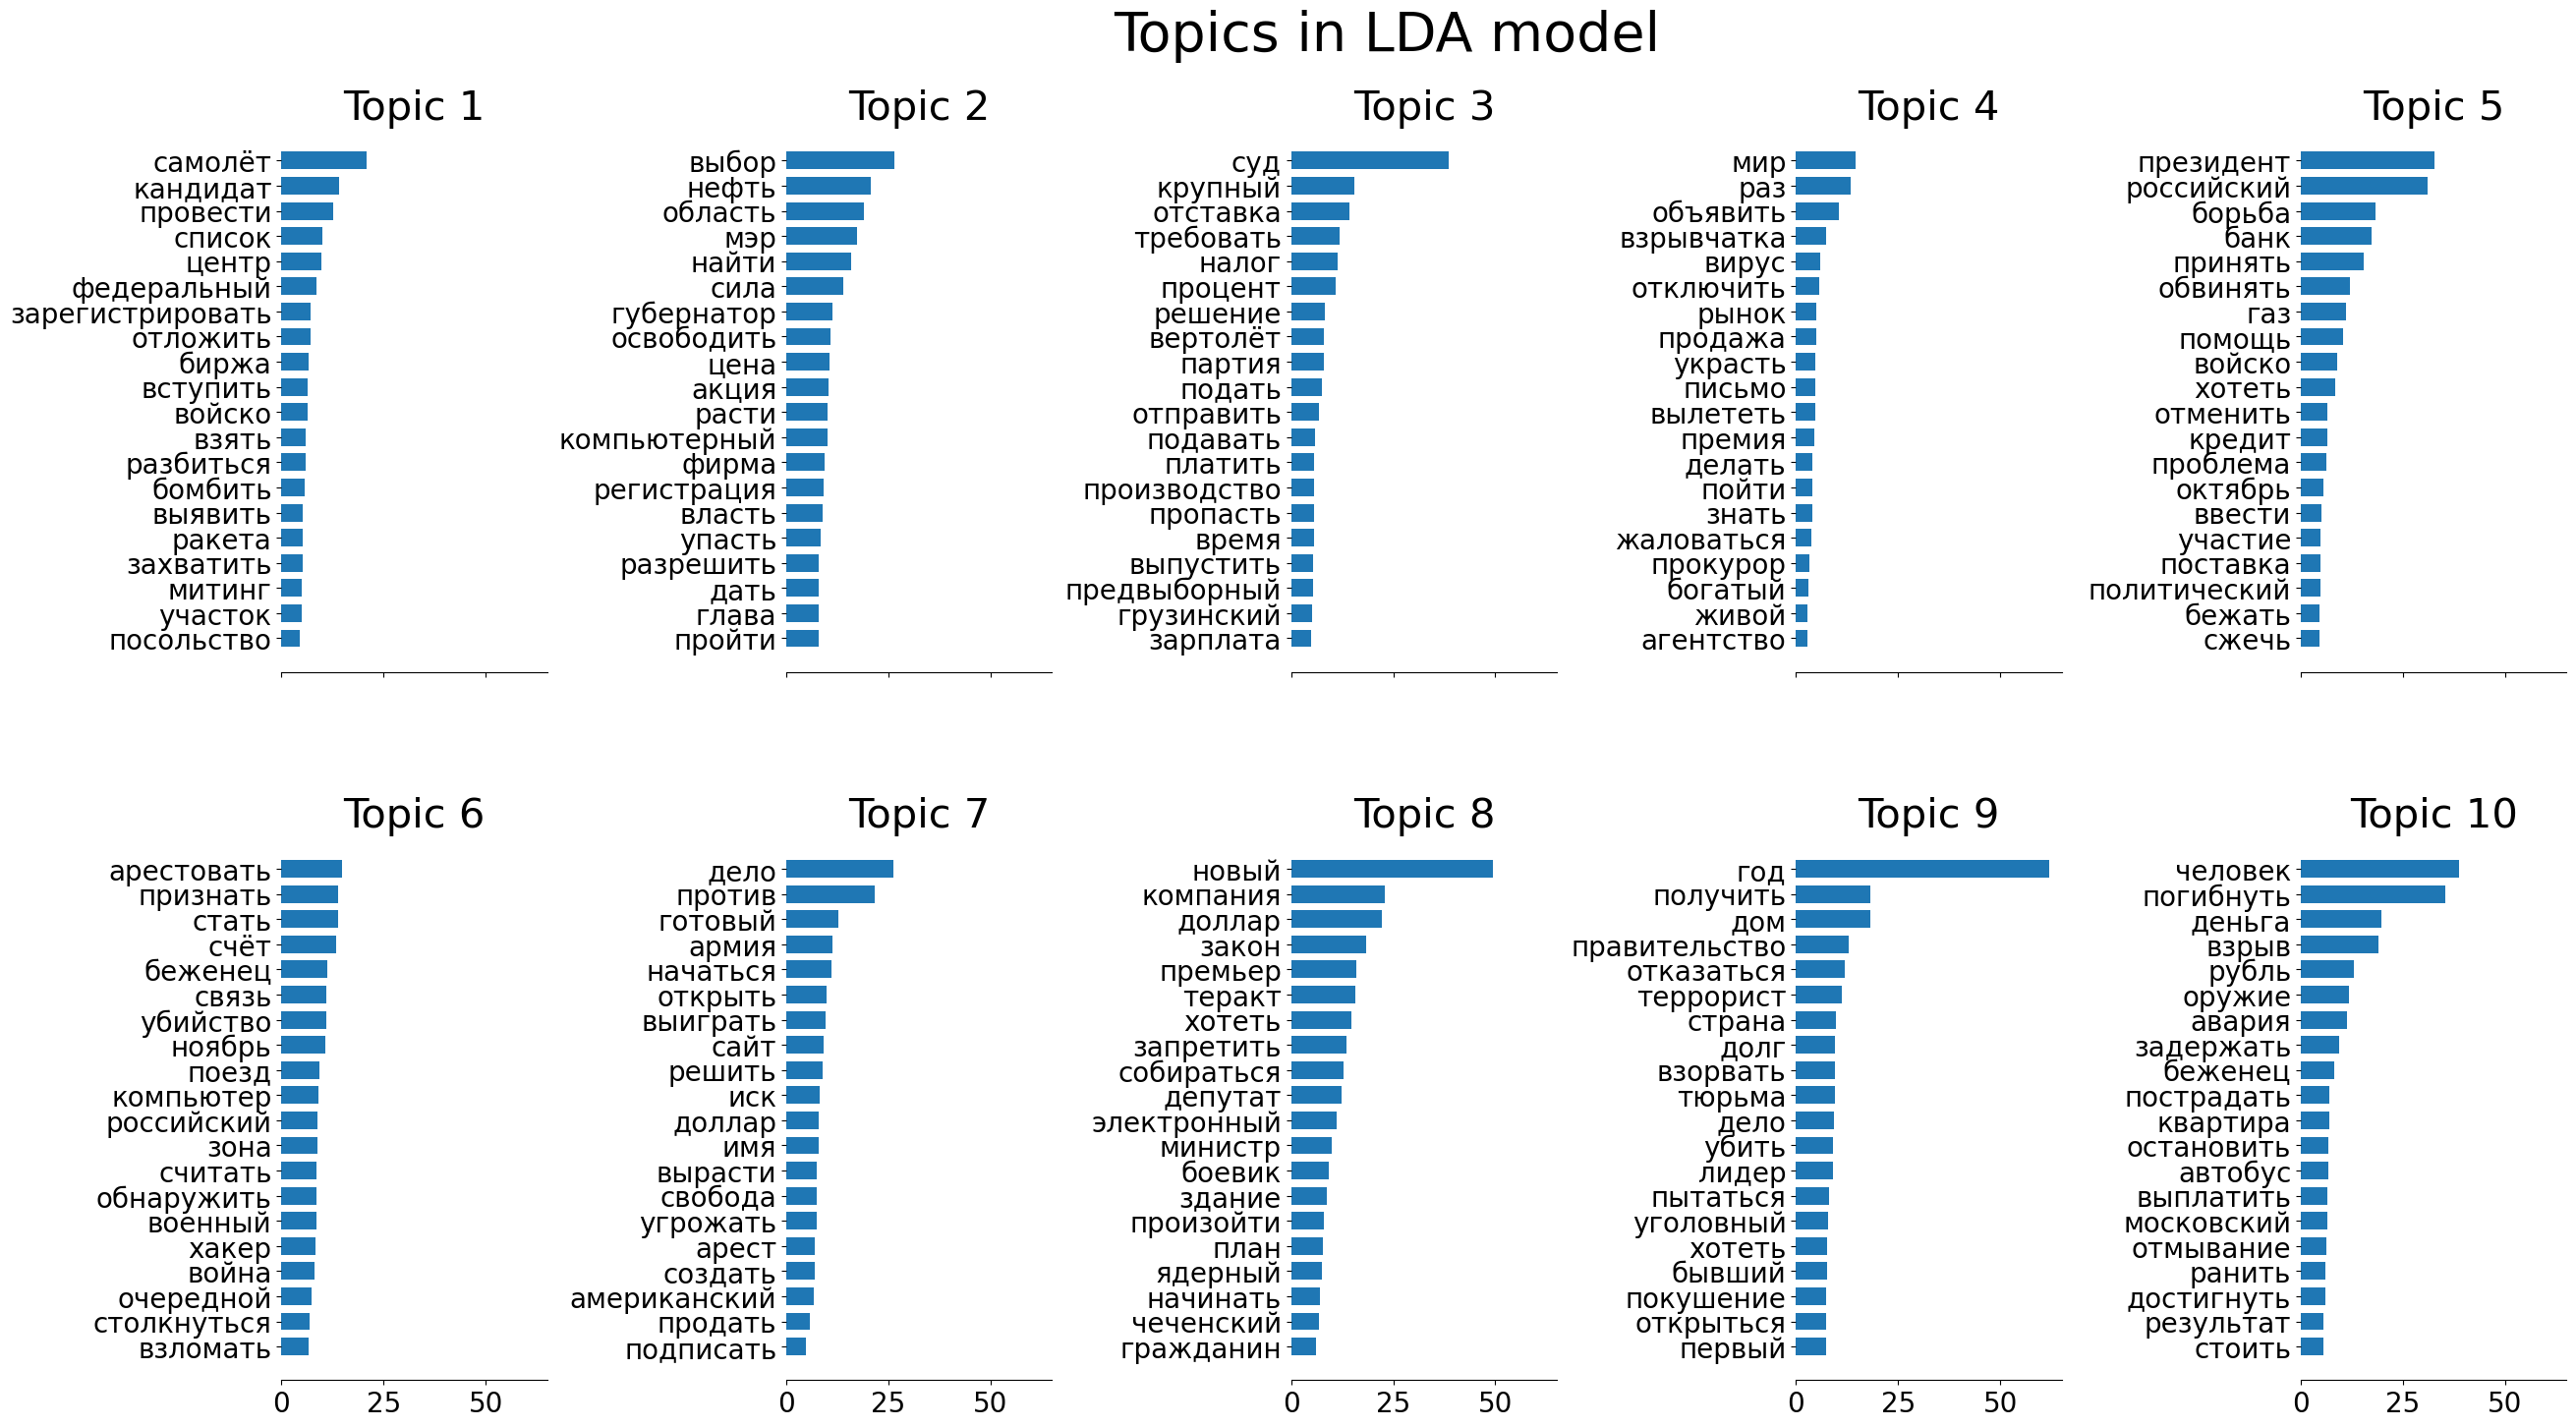

In [20]:
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")